In [1]:
!rm -rf /kaggle/working/*
%reset -f

import gc

def reset_memory():
    # Delete all variables.
    for var in gc.get_objects():
        try:
            del var
        except:
            pass

    # Run the garbage collector.
    gc.collect()

    print("Memory has been reset")

# Call the function to reset memory

reset_memory()

Memory has been reset


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet101, MobileNetV2, EfficientNetB0, DenseNet121, VGG19, Xception, InceptionV3, InceptionResNetV2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

2025-07-03 07:17:30.510875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751527050.715111      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751527050.768364      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data_dir = "/kaggle/input/kdef-dataset/CK/CK+/"
batch_size = 8
img_size = (224, 224)

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 981 files belonging to 7 classes.
Using 785 files for training.


I0000 00:00:1751527086.093951      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 981 files belonging to 7 classes.
Using 196 files for validation.


In [4]:
# Load pre-trained ResNet101 model for transfer learning (without the top classification layer)
base_model = ResNet101(weights="imagenet", include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Freeze the layers of the base model to prevent them from being updated during training
base_model.trainable = True

from keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(filepath ='/kaggle/working/best_model.keras', monitor='val_accuracy', mode = 'max', save_best_only=True)

# Add custom layers on top for emotion classification
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dense(len(class_names), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])# Train the model

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [5]:
history = model.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=batch_size, callbacks=[model_checkpoint])

Epoch 1/50


I0000 00:00:1751527227.436924     102 service.cc:148] XLA service 0x7a27540037b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751527227.437577     102 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751527236.733572     102 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751527266.874860     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


99/99 ━━━━━━━━━━━━━━━━━━━━ 200s 660ms/step - accuracy: 0.6238 - loss: 1.9454 - val_accuracy: 0.5153 - val_loss: 5.1240
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 231ms/step - accuracy: 0.9347 - loss: 0.2908 - val_accuracy: 0.7092 - val_loss: 1.4095
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 229ms/step - accuracy: 0.9649 - loss: 0.1546 - val_accuracy: 0.8827 - val_loss: 0.6826
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.9653 - loss: 0.2219 - val_accuracy: 0.7347 - val_loss: 0.9526
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.9696 - loss: 0.2238 - val_accuracy: 0.3010 - val_loss: 85.1607
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.8904 - loss: 0.9186 - val_accuracy: 0.8367 - val_loss: 0.8780
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 233ms/step - accuracy: 0.9751 - loss: 0.1389 - val_accuracy: 0.9898 - val_loss: 0.0400
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.9860 - loss: 0.0552 - val_accuracy: 0.9

In [6]:
model.load_weights(filepath ='/kaggle/working/best_model.keras')
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("Accuracy of our model on test data : " , model.evaluate(val_ds)[1]*100 , "%")

25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.9932 - loss: 0.0135
Accuracy of our model on test data :  99.48979616165161 %


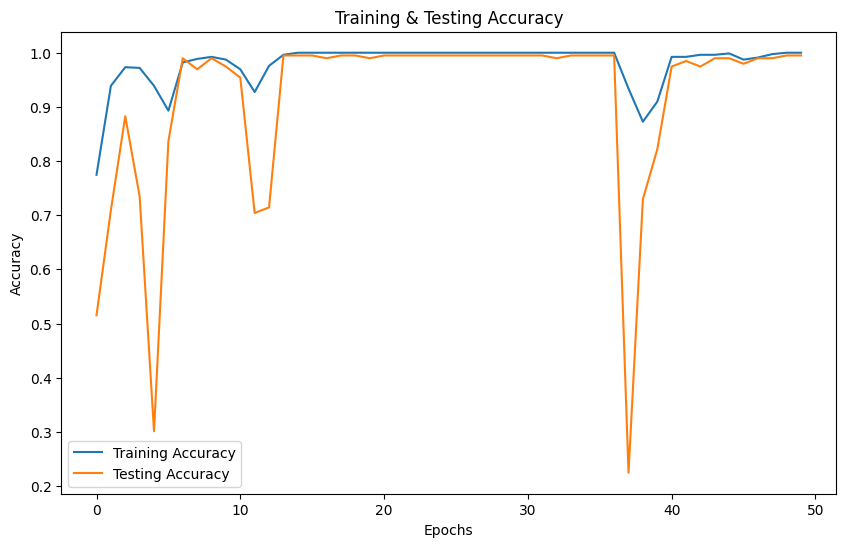

In [7]:
epochs = [i for i in range(50)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

plt.figure(figsize = (10,6))
plt.plot(epochs , train_acc , label = 'Training Accuracy')
plt.plot(epochs , test_acc , label = 'Testing Accuracy')
plt.title('Training & Testing Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig('Acc.png', dpi=1200)
plt.show()

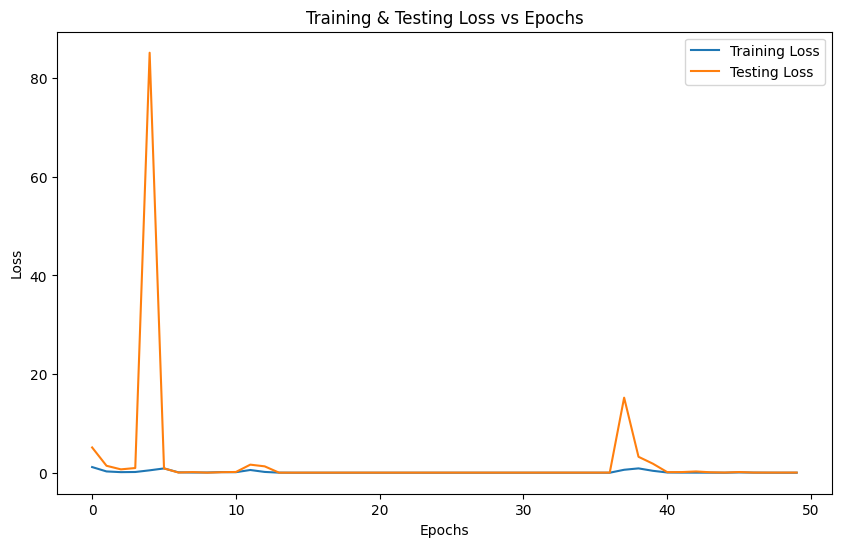

In [8]:
plt.figure(figsize = (10,6))
plt.plot(epochs , train_loss , label = 'Training Loss')
plt.plot(epochs , test_loss , label = 'Testing Loss')
plt.title('Training & Testing Loss vs Epochs')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('Loss.png', dpi=1200)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


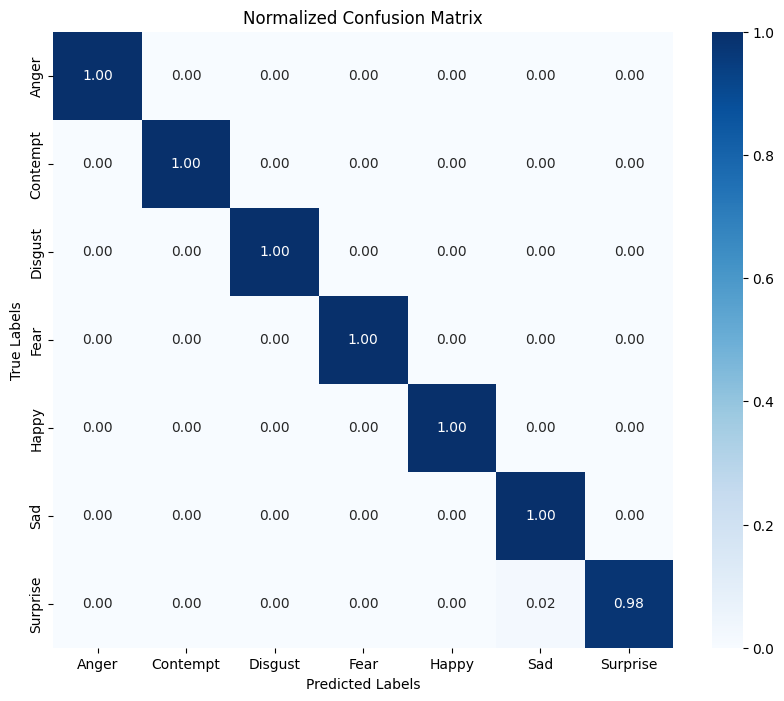

Classification Report:
              precision    recall  f1-score   support

       Anger       1.00      1.00      1.00        31
    Contempt       1.00      1.00      1.00        10
     Disgust       1.00      1.00      1.00        36
        Fear       1.00      1.00      1.00        20
       Happy       1.00      1.00      1.00        43
         Sad       0.88      1.00      0.93         7
    Surprise       1.00      0.98      0.99        49

    accuracy                           0.99       196
   macro avg       0.98      1.00      0.99       196
weighted avg       1.00      0.99      1.00       196



In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Get class names
class_names = sorted(entry.name for entry in os.scandir(data_dir) if entry.is_dir())

# Extract true labels and predicted labels
labels_true = []
labels_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    labels_true.extend(labels.numpy())
    labels_pred.extend(np.argmax(preds, axis=1))

labels_true = np.array(labels_true)
labels_pred = np.array(labels_pred)

# Compute confusion matrix
cm = confusion_matrix(labels_true, labels_pred)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.savefig('Conf_Mat.png', dpi=1200)
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(labels_true, labels_pred, target_names=class_names))